In [23]:
# Specifiy file directory 
path = (r'C:\Users\boyuan\Desktop\Juypter\July 29\\')

In [24]:
# Import all required python packages
import os
import math
import pandas as pd
import numpy as np
import datetime
from datetime import time
from datetime import datetime

from datetime import datetime, timedelta
import math

import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

from matplotlib import gridspec
import pyodbc
from collections import Iterable
from matplotlib.ticker import MaxNLocator
import pdb

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from mlxtend.preprocessing import standardize
from sklearn.metrics import mean_squared_error

import pymc3 as pm
from pymc3.gp.util import plot_gp_dist

import arviz as az
import warnings
warnings.simplefilter('ignore')
start = datetime.now()

In [25]:
# Read the PHM08 dataset from the txt file into a panda dataframe
#df = pd.read_csv(path+'train.txt', sep=" ", header=None)
df_all = pd.read_csv(path+'train_FD001.txt', sep=" ", header=None)

# Display the first 5 rows of the dataframe
# As stated inside the project report, the first column is the engine Nnumber,
# second column is the engine's corresponding run-cycle,
# and column 3 - 27 are the sensor readings inside the simulated jet engine,
# Please referr to https://www.semanticscholar.org/paper/Damage-propagation-modeling-for-aircraft-engine-Saxena-Goebel/026d286e149b17995d0f8c0abb4f060eb8e5d809
# for details
df_all = df_all.iloc[:,[0,1,7]]
df_all.head(5)

,0,1,7
0,1,1,1589.70
1,1,2,1591.82
2,1,3,1587.99
3,1,4,1582.79
4,1,5,1582.85


In [26]:
df_all.shape

(20631, 3)

In [27]:
def apply_GPR(df_norm,missing_percentage,engine_id):

    failure_cycle = df_norm.iloc[-1,1]
    
    drop_index = df_norm.sample(frac=missing_percentage).index
    
    df_drop = df_norm.drop(drop_index)
    

    with pm.Model() as model:
    
        # Initialize the piror (i.e inital hyper-parameters) for the kernel function 
        ℓ = pm.Gamma("ℓ", alpha=2, beta=1)

        # The Half Cauchy distribution is selected and used instead of the standard normal distribution
        # Compared to normal distribution Cauchu distribition has a longer tails 
        # The sensor readings might contain outliers that are very large/small
        # Thus Cauchy distribution is used here
        η = pm.HalfCauchy("η", beta=5)

        cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
        gp = pm.gp.Marginal(cov_func=cov)

        σ = pm.HalfCauchy("σ", beta=5)
        #y_ = gp.marginal_likelihood("y", X=np.array(df_drop[df_drop[0]==engine_id][0].index).reshape(-1,1),\
        #                            y=df_drop[df_drop[0]==engine_id][2].values, noise=σ)
        
        y_ = gp.marginal_likelihood("y", X=np.array(df_drop[df_drop[0]==engine_id][1].values).reshape(-1,1),\
                                    y=df_drop[df_drop[0]==engine_id][2].values, noise=σ)

        # Use the built in function to calculate the maximum a posterier propbability
        mp = pm.find_MAP()

    # New values from x=0 to x=200
    X_new = np.linspace(1, failure_cycle+1, failure_cycle+1)[:,None]

    # Add the GP conditional to the model, given the new X values
    with model:
        f_pred = gp.conditional("f_pred", X_new)

    # To use the MAP values, you can just replace the trace with a length-1 list with `mp`
    with model:
        pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)
    
    # Make prediction based on the samples presented
    with model:
        y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
        y_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=2000)
    
    df_ground_truth = df_norm.iloc[np.sort(drop_index),:]
    
    RMSE = list()

    for i in range(y_samples["y_pred"].shape[0]):

        local_prediction = y_samples["y_pred"][i,:].T[np.sort(drop_index)]
        rmse_error = mean_squared_error(df_ground_truth[2].values, local_prediction)

        RMSE.append(rmse_error)
        
    RMSE = np.array(RMSE)
    
    return(round(RMSE.max(),3), round(RMSE.min(),3), round(RMSE.mean(),3),\
           round(RMSE.std(),3), round(np.median(RMSE),3), list(drop_index))
    

In [28]:
x = df_all.values

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

df_norm_all = pd.DataFrame(x_scaled)
df_norm_all[0] = df_all[0]
df_norm_all[1] = df_all[1]

In [29]:
df_norm_all.head(5)

,0,1,2
0,1,1,0.406802
1,1,2,0.453019
2,1,3,0.369523
3,1,4,0.256159
4,1,5,0.257467


In [30]:
def apply_Dummy(df_norm,drop_index):
    
    dummy_rmse_list = list()
    
    for engine_id in list(np.sort(df_norm[0].unique())[:26]):
        
        df = df_norm[df_norm[0]==engine_id]
        df = df.reset_index(drop=True)

        df_ground_truth = df.iloc[np.sort(drop_index[engine_id-1]),:][2].values
        
        df.iloc[np.sort(drop_index[engine_id-1]),2] = 0
        df = df.replace(0,method = 'ffill')
        df = df.replace(0,method = 'bfill')
    
        rmse_engine = round(mean_squared_error(df_ground_truth, df.iloc[np.sort(drop_index[engine_id-1]),:][2].values),3)
        
        dummy_rmse_list.append(rmse_engine)
    
    return dummy_rmse_list

In [32]:
start = datetime.now()

dict_summary = dict()

drop_25_index_list = list()
drop_50_index_list = list()
drop_75_index_list = list()

for engine_id in np.sort(df_all[0].unique()[:26]):
    
    df = df_all[df_all[0]==engine_id]
    df = df.reset_index(drop=True)
    
    x = df.values

    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    df_norm = pd.DataFrame(x_scaled)
    df_norm[0] = df[0]
    df_norm[1] = df[1]
    
    RMSE_25_max, RMSE_25_min, RMSE_25_mean, RMSE_25_std, RMSE_25_med, drop_25 \
    = apply_GPR(df_norm,0.25,engine_id)
    
    RMSE_50_max, RMSE_50_min, RMSE_50_mean, RMSE_50_std, RMSE_50_med,drop_50 \
    = apply_GPR(df_norm,0.5,engine_id)
        
    RMSE_75_max, RMSE_75_min, RMSE_75_mean, RMSE_75_std, RMSE_75_med,drop_75 \
    = apply_GPR(df_norm,0.75,engine_id)
    
    dict_summary[engine_id] = [RMSE_25_max, RMSE_25_min, RMSE_25_mean, RMSE_25_std, RMSE_25_med,\
                               RMSE_50_max, RMSE_50_min, RMSE_50_mean, RMSE_50_std, RMSE_50_med,\
                               RMSE_75_max, RMSE_75_min, RMSE_75_mean, RMSE_75_std, RMSE_75_med ]
    
    drop_25_index_list.append(drop_25)
    drop_50_index_list.append(drop_50)
    drop_75_index_list.append(drop_75)
    
    end = datetime.now()
    print('Engine No.{}/{} Complete ...'.format(engine_id,25))
    print('Epochs Used: {}'.format(end - start))
    print('{}'.format(dict_summary[engine_id]))
    
    
end = datetime.now()
print('Time Used: {}\n'.format(end - start))

Engine No.1/25 Complete ...
Epochs Used: 0:05:48.580650
[0.086, 0.02, 0.05, 0.009, 0.05, 0.088, 0.036, 0.056, 0.007, 0.055, 0.12, 0.043, 0.069, 0.01, 0.068]


Engine No.2/25 Complete ...
Epochs Used: 0:17:12.359542
[0.047, 0.016, 0.028, 0.004, 0.028, 0.044, 0.02, 0.03, 0.003, 0.03, 0.053, 0.025, 0.035, 0.004, 0.035]


Engine No.3/25 Complete ...
Epochs Used: 0:22:23.889866
[0.063, 0.018, 0.036, 0.007, 0.036, 0.067, 0.025, 0.042, 0.006, 0.042, 0.088, 0.033, 0.056, 0.008, 0.055]


Engine No.4/25 Complete ...
Epochs Used: 0:28:02.059324
[0.047, 0.013, 0.026, 0.005, 0.026, 0.04, 0.016, 0.027, 0.004, 0.027, 0.103, 0.021, 0.041, 0.009, 0.04]


Engine No.5/25 Complete ...
Epochs Used: 0:38:09.194569
[0.043, 0.013, 0.028, 0.004, 0.027, 0.043, 0.023, 0.032, 0.003, 0.032, 0.058, 0.025, 0.038, 0.004, 0.037]


Engine No.6/25 Complete ...
Epochs Used: 0:43:47.586927
[0.098, 0.032, 0.054, 0.009, 0.054, 0.078, 0.03, 0.051, 0.007, 0.051, 0.083, 0.034, 0.054, 0.007, 0.054]


Engine No.7/25 Complete ...
Epochs Used: 0:53:17.151626
[0.056, 0.019, 0.037, 0.005, 0.036, 0.056, 0.025, 0.038, 0.004, 0.038, 0.079, 0.031, 0.047, 0.007, 0.046]


Engine No.8/25 Complete ...
Epochs Used: 0:57:23.247328
[0.078, 0.014, 0.041, 0.009, 0.041, 0.087, 0.024, 0.049, 0.009, 0.048, 0.119, 0.037, 0.067, 0.011, 0.066]


Engine No.9/25 Complete ...
Epochs Used: 1:03:35.963830
[0.051, 0.012, 0.028, 0.005, 0.028, 0.052, 0.022, 0.035, 0.005, 0.035, 0.093, 0.028, 0.046, 0.008, 0.045]


Engine No.10/25 Complete ...
Epochs Used: 1:10:59.245067
[0.036, 0.011, 0.022, 0.004, 0.021, 0.029, 0.013, 0.021, 0.003, 0.021, 0.035, 0.014, 0.022, 0.003, 0.022]


Engine No.11/25 Complete ...
Epochs Used: 1:19:20.818743
[0.044, 0.015, 0.028, 0.004, 0.028, 0.049, 0.019, 0.032, 0.004, 0.031, 0.09, 0.024, 0.04, 0.008, 0.038]


Engine No.12/25 Complete ...
Epochs Used: 1:24:14.488203
[0.09, 0.022, 0.052, 0.011, 0.051, 0.104, 0.037, 0.061, 0.009, 0.061, 0.134, 0.048, 0.076, 0.012, 0.075]


Engine No.13/25 Complete ...
Epochs Used: 1:28:49.486680
[0.063, 0.014, 0.034, 0.006, 0.033, 0.065, 0.021, 0.036, 0.005, 0.036, 0.076, 0.024, 0.041, 0.007, 0.04]


Engine No.14/25 Complete ...
Epochs Used: 1:34:15.320936
[0.068, 0.02, 0.039, 0.007, 0.039, 0.069, 0.026, 0.043, 0.006, 0.042, 0.122, 0.033, 0.055, 0.01, 0.053]


Engine No.15/25 Complete ...
Epochs Used: 1:40:51.718586
[0.053, 0.017, 0.033, 0.005, 0.032, 0.05, 0.02, 0.033, 0.004, 0.032, 0.058, 0.022, 0.034, 0.005, 0.033]


Engine No.16/25 Complete ...
Epochs Used: 1:47:36.774075
[0.095, 0.029, 0.055, 0.01, 0.054, 0.08, 0.036, 0.058, 0.007, 0.057, 0.131, 0.045, 0.079, 0.011, 0.078]


Engine No.17/25 Complete ...
Epochs Used: 1:58:15.190390
[0.051, 0.016, 0.03, 0.004, 0.029, 0.052, 0.021, 0.033, 0.004, 0.033, 0.05, 0.023, 0.033, 0.004, 0.033]


Engine No.18/25 Complete ...
Epochs Used: 2:04:19.030628
[0.048, 0.015, 0.029, 0.005, 0.029, 0.047, 0.019, 0.032, 0.005, 0.032, 0.094, 0.026, 0.046, 0.009, 0.045]


Engine No.19/25 Complete ...
Epochs Used: 2:08:46.584145
[0.11, 0.022, 0.065, 0.013, 0.064, 0.107, 0.042, 0.069, 0.01, 0.069, 0.132, 0.049, 0.077, 0.011, 0.076]


Engine No.20/25 Complete ...
Epochs Used: 2:16:56.595674
[0.06, 0.021, 0.037, 0.006, 0.036, 0.057, 0.024, 0.04, 0.005, 0.04, 0.069, 0.029, 0.045, 0.005, 0.044]


Engine No.21/25 Complete ...
Epochs Used: 2:22:55.654204
[0.112, 0.037, 0.066, 0.011, 0.066, 0.105, 0.039, 0.065, 0.009, 0.065, 0.161, 0.058, 0.092, 0.014, 0.091]


Engine No.22/25 Complete ...
Epochs Used: 2:29:31.210155
[0.066, 0.019, 0.037, 0.007, 0.036, 0.067, 0.025, 0.044, 0.006, 0.043, 0.105, 0.038, 0.059, 0.01, 0.058]


Engine No.23/25 Complete ...
Epochs Used: 2:34:19.464085
[0.115, 0.028, 0.063, 0.013, 0.062, 0.117, 0.041, 0.069, 0.01, 0.068, 0.238, 0.058, 0.101, 0.024, 0.096]


Engine No.24/25 Complete ...
Epochs Used: 2:38:26.346948
[0.059, 0.015, 0.035, 0.007, 0.034, 0.056, 0.018, 0.035, 0.005, 0.035, 0.105, 0.022, 0.043, 0.009, 0.042]


Engine No.25/25 Complete ...
Epochs Used: 2:46:26.287124
[0.061, 0.018, 0.036, 0.006, 0.036, 0.05, 0.023, 0.036, 0.004, 0.035, 0.078, 0.027, 0.04, 0.005, 0.04]


Engine No.26/25 Complete ...
Epochs Used: 2:52:37.675178
[0.069, 0.019, 0.04, 0.007, 0.04, 0.068, 0.027, 0.044, 0.006, 0.044, 0.071, 0.033, 0.048, 0.006, 0.047]
Time Used: 2:52:37.675178



In [33]:
dummy_25_rmse_list = apply_Dummy(df_norm_all,drop_25_index_list)
dummy_50_rmse_list = apply_Dummy(df_norm_all,drop_50_index_list)
dummy_75_rmse_list = apply_Dummy(df_norm_all,drop_75_index_list)

print(dummy_25_rmse_list)

[0.016, 0.016, 0.015, 0.013, 0.014, 0.016, 0.014, 0.013, 0.012, 0.013, 0.017, 0.017, 0.013, 0.014, 0.018, 0.018, 0.014, 0.014, 0.013, 0.013, 0.016, 0.01, 0.017, 0.015, 0.014, 0.011]


In [34]:
d = {'25%_Dummy_Mean':dummy_25_rmse_list, '50%_Dummy_Mean': dummy_50_rmse_list,'75%_Dummy_Mean': dummy_75_rmse_list}

df_dummy_rmse_summary = pd.DataFrame(data=d)
df_dummy_rmse_summary.head(10)

,25%_Dummy_Mean,50%_Dummy_Mean,75%_Dummy_Mean
0,0.016,0.016,0.018
1,0.016,0.015,0.014
2,0.015,0.012,0.013
3,0.013,0.011,0.017
4,0.014,0.017,0.015
5,0.016,0.014,0.012
6,0.014,0.011,0.011
7,0.013,0.010,0.022
8,0.012,0.015,0.015
9,0.013,0.015,0.014


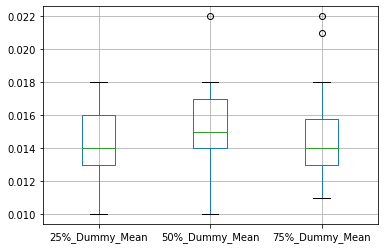

In [35]:
boxplot = df_dummy_rmse_summary.boxplot(column=['25%_Dummy_Mean', '50%_Dummy_Mean', '75%_Dummy_Mean'])

In [42]:
round(df_dummy_rmse_summary['25%_Dummy_Mean'].mean(),3)

0.014

In [36]:
df_gp_rmse_summary = pd.DataFrame(columns=['25%_Max', '25%_Min','25%_Mean','25%_Std','25%_Med',\
                                           '50%_Max', '50%_Min','50%_Mean','50%_Std','50%_Med',\
                                           '75%_Max', '75%_Min','75%_Mean','75%_Std','75%_Med'])


for engine_no in np.sort(df_all[0].unique()[:26]):
    
    #df_entry = pd.DataFrame(dict_summary[engine_no], columns = df_gp_rmse_summary.columns)
    df_gp_rmse_summary.loc[engine_no] = dict_summary[engine_no]
    
    #df_gp_rmse_summary.append(dict_summary[engine_no],ignore_index=False)


In [37]:
df_gp_rmse_summary

,25%_Max,25%_Min,25%_Mean,25%_Std,25%_Med,50%_Max,50%_Min,50%_Mean,50%_Std,50%_Med,75%_Max,75%_Min,75%_Mean,75%_Std,75%_Med
1,0.086,0.020,0.050,0.009,0.050,0.088,0.036,0.056,0.007,0.055,0.120,0.043,0.069,0.010,0.068
2,0.047,0.016,0.028,0.004,0.028,0.044,0.020,0.030,0.003,0.030,0.053,0.025,0.035,0.004,0.035
3,0.063,0.018,0.036,0.007,0.036,0.067,0.025,0.042,0.006,0.042,0.088,0.033,0.056,0.008,0.055
4,0.047,0.013,0.026,0.005,0.026,0.040,0.016,0.027,0.004,0.027,0.103,0.021,0.041,0.009,0.040
5,0.043,0.013,0.028,0.004,0.027,0.043,0.023,0.032,0.003,0.032,0.058,0.025,0.038,0.004,0.037
6,0.098,0.032,0.054,0.009,0.054,0.078,0.030,0.051,0.007,0.051,0.083,0.034,0.054,0.007,0.054
7,0.056,0.019,0.037,0.005,0.036,0.056,0.025,0.038,0.004,0.038,0.079,0.031,0.047,0.007,0.046
8,0.078,0.014,0.041,0.009,0.041,0.087,0.024,0.049,0.009,0.048,0.119,0.037,0.067,0.011,0.066
9,0.051,0.012,0.028,0.005,0.028,0.052,0.022,0.035,0.005,0.035,0.093,0.028,0.046,0.008,0.045
10,0.036,0.011,0.022,0.004,0.021,0.029,0.013,0.021,0.003,0.021,0.035,0.014,0.022,0.003,0.022


In [38]:
df_gp_rmse_summary.to_excel(path+'25_Engines_GP_25_50_75_RMSE_Summary.xlsx')

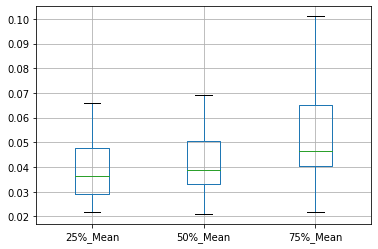

In [39]:
boxplot = df_gp_rmse_summary.boxplot(column=['25%_Mean', '50%_Mean', '75%_Mean'])

### Experiment 2 --- Comparsion between Dummy Model and GP Regression

In [46]:
round(df_dummy_rmse_summary['75%_Dummy_Mean'].mean(),3)

0.014

In [50]:
dummy_mean = np.array([round(df_dummy_rmse_summary['25%_Dummy_Mean'].mean(),3), \
                      round(df_dummy_rmse_summary['50%_Dummy_Mean'].mean(),3), \
                      round(df_dummy_rmse_summary['75%_Dummy_Mean'].mean(),3)])

gpr_mean = np.array([round(df_gp_rmse_summary['25%_Mean'].mean(),3), \
                    round(df_gp_rmse_summary['50%_Mean'].mean(),3), \
                    round(df_gp_rmse_summary['75%_Mean'].mean(),3)])


In [52]:
gpr_mean 

array([0.04 , 0.043, 0.053])

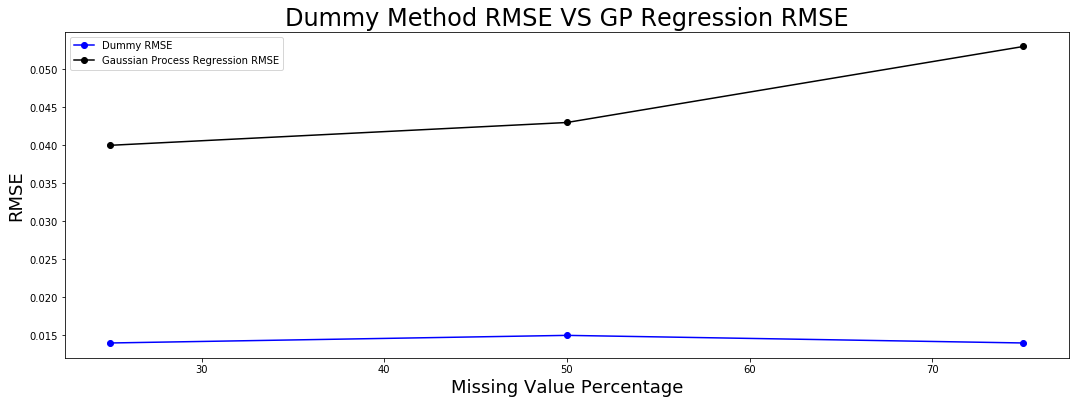

In [51]:
percent_error = [25,50,75]

plt.figure(figsize=(18,6))
plt.plot(percent_error,dummy_mean,'o-',color='blue',label='Dummy RMSE')

plt.plot(percent_error,gpr_mean,'o-',color='black',label='Gaussian Process Regression RMSE')

plt.xlabel('Missing Value Percentage',fontsize=18)
plt.ylabel('RMSE',fontsize=18)
plt.title('Dummy Method RMSE VS GP Regression RMSE',fontsize=24)

plt.legend()